## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: by Адиль Исмаилов from иу9 !)!))

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm.auto import tqdm
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [97]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [98]:
images_train, labels_train = next(iter(train_loader))

In [99]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

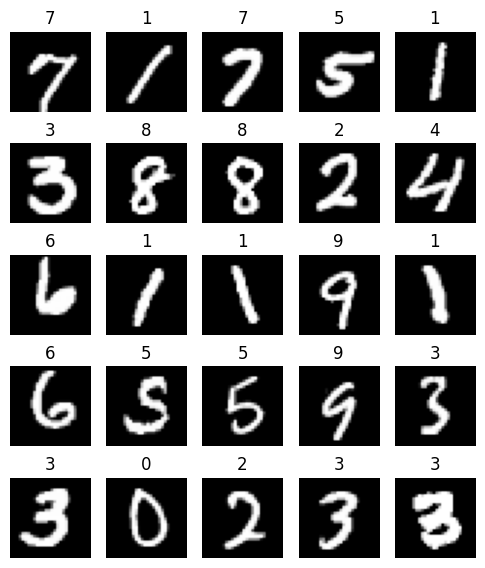

In [100]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [101]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def init_layer_uniform(layer, a=0, b=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [102]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [103]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

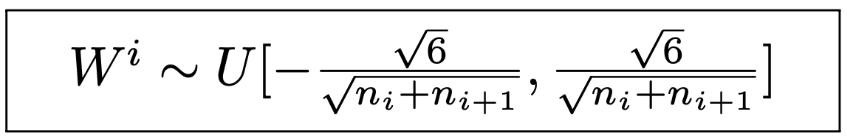

In [161]:
def train(train_dataloader, val_dataloader, network, optimizer, n_epochs=5, is_conv=False):
    train_loss_epochs = []
    val_loss_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs = []
    loss_fn = torch.nn.NLLLoss()
    
    for epoch in range(n_epochs):
        network.train()
        train_losses = []
        train_accuracies = []
        
        for x_train, y_train in tqdm(train_dataloader):
            if not is_conv:
                x_train = x_train.view(x_train.size(0), -1)
            activations = network(x_train)
            loss = loss_fn(activations, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_losses.append(loss.item())
            pred = torch.argmax(activations, dim=-1)
            train_accuracies.append((pred == y_train).float().mean().item())
            
        train_loss_epochs.append(np.mean(train_losses))
        train_accuracy_epochs.append(np.mean(train_accuracies))
        
        network.eval()
        val_losses = []
        val_accuracies = []
        
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                if not is_conv:
                    x_val = x_val.view(x_val.size(0), -1)
                activations = network(x_val)
                loss = loss_fn(activations, y_val)
                
                val_losses.append(loss.item())
                pred = torch.argmax(activations, dim=-1)
                val_accuracies.append((pred == y_val).float().mean().item())
        
        val_loss_epochs.append(np.mean(val_losses))
        val_accuracy_epochs.append(np.mean(val_accuracies))

    return train_loss_epochs, val_loss_epochs, train_accuracy_epochs, val_accuracy_epochs

In [166]:
def plot_train(he_results, xavier_results, labels):
    he_train_loss, he_val_loss, he_train_acc, he_val_acc = he_results
    xav_train_loss, xav_val_loss, xav_train_acc, xav_val_acc = xavier_results
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(he_train_loss, label=labels[0], linewidth=2)
    plt.plot(he_val_loss, label=labels[1], linewidth=2, linestyle='--')
    plt.plot(xav_train_loss, label=labels[2], linewidth=2)
    plt.plot(xav_val_loss, label=labels[3], linewidth=2, linestyle='--')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(he_train_acc, label=labels[0], linewidth=2)
    plt.plot(he_val_acc, label=labels[1], linewidth=2, linestyle='--')
    plt.plot(xav_train_acc, label=labels[2], linewidth=2)
    plt.plot(xav_val_acc, label=labels[3], linewidth=2, linestyle='--')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [137]:
class StatsHook:
    def __init__(self, name):
        self.name = name
        self.forward_stds = []
        self.backward_stds = [] 
    
    def forward_hook(self, module, input_, output):
        std = input_[0].std().item()
        self.forward_stds.append(std)
    
    def backward_hook(self, module, grad_input, grad_output):
        if grad_input[0] is not None:
            std = grad_input[0].std().item()
            self.backward_stds.append(std)

    def forward_mean(self):
        return np.mean(self.forward_stds)
        
    def forward_std(self):
        return np.std(self.forward_stds)

    def backward_mean(self):
        return np.mean(self.backward_stds)
        
    def backward_std(self):
        return np.std(self.backward_stds)

def MakeLayers():
    layer_1 = nn.Linear(28*28, 256)
    layer_2 = nn.Linear(256, 10)

    hook1 = StatsHook("layer 1")
    hook2 = StatsHook("layer 2")
    
    layer_1.register_forward_hook(hook1.forward_hook)
    layer_2.register_forward_hook(hook2.forward_hook)
    
    layer_1.register_backward_hook(hook1.backward_hook)
    layer_2.register_backward_hook(hook2.backward_hook)

    return [layer_1, layer_2], [hook1, hook2]

def NetworkHe(layers, out=True):
    std1, std2 = 2 / 256, 2 / 10
    if not out:
        std1, std2 = 2 / (28 * 28), 2 / 256
    init_layer(layers[0], 0, std1)
    init_layer(layers[1], 0, std2)
    
    network_he = nn.Sequential(
        layers[0],
        nn.ReLU(),
        layers[1],
        nn.LogSoftmax(dim=1)
    )

    return network_he

def NetworkXavier(layers):
    b_layer1 = np.sqrt(6) / np.sqrt(28 * 28 + 256)
    b_layer2 = np.sqrt(6) / np.sqrt(256 + 10)
    a_layer1, a_layer2 = -b_layer1, -b_layer2
    
    init_layer_uniform(layers[0], a_layer1, b_layer1)
    init_layer_uniform(layers[1], a_layer2, b_layer2)
    
    network_xav = nn.Sequential(
        layers[0],
        nn.Tanh(),
        layers[1],
        nn.LogSoftmax(dim=1)
    )

    return network_xav

In [145]:
def LayerDiff(hooks):
    layer1_forward_mean = hooks[0].forward_mean()
    layer2_forward_mean = hooks[1].forward_mean()
    layer1_forward_std = hooks[0].forward_std()
    layer2_forward_std = hooks[1].forward_std()

    layer1_backward_mean = hooks[0].backward_mean()
    layer2_backward_mean = hooks[1].backward_mean()
    layer1_backward_std = hooks[0].backward_std()
    layer2_backward_std = hooks[1].backward_std()
    
    forward_mean_diff = abs(layer1_forward_mean - layer2_forward_mean)
    forward_std_diff = abs(layer1_forward_std - layer2_forward_std)
    backward_mean_diff = abs(layer1_backward_mean - layer2_backward_mean)
    backward_std_diff = abs(layer1_backward_std - layer2_backward_std)
    
    return {
        'forward_mean': forward_mean_diff,
        'forward_std': forward_std_diff,
        'backward_mean': backward_mean_diff,
        'backward_std': backward_std_diff
    }

def create_df_stats(he_stats, xavier_stats):
    df = pd.DataFrame({
        'Init weights': ['He', 'Xavier'],
        'forward_mean_diff': [he_stats['forward_mean'], xavier_stats['forward_mean']],
        'forward_std_diff': [he_stats['forward_std'], xavier_stats['forward_std']],
        'backward_mean_diff': [he_stats['backward_mean'], xavier_stats['backward_mean']],
        'backward_std_diff': [he_stats['backward_std'], xavier_stats['backward_std']]
    })
    
    return df

In [139]:
layers_he, hooks_he = MakeLayers()
layers_xav, hooks_xav = MakeLayers()

network_he = NetworkHe(layers_he)
network_xav = NetworkXavier(layers_xav)

optimizer_he = torch.optim.Adam(network_he.parameters(), lr=0.001)
optimizer_xav = torch.optim.Adam(network_xav.parameters(), lr=0.001)

In [141]:
he_results = train(train_loader, test_loader, network_he, optimizer_he)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [142]:
xavier_results = train(train_loader, test_loader, network_xav, optimizer_xav)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

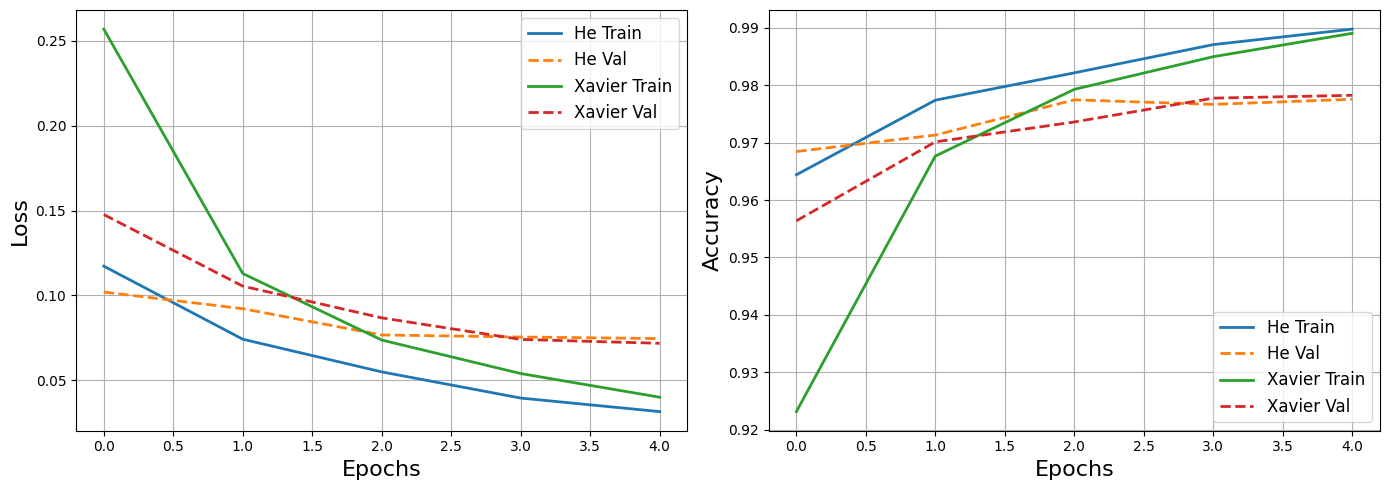

In [167]:
plot_train(he_results, xavier_results, ['He Train', 'He Val', 'Xavier Train', 'Xavier Val'])

In [146]:
he_stats = LayerDiff(hooks_he)
xavier_stats = LayerDiff(hooks_xav)

df_st = create_df_stats(he_stats, xavier_stats)
df_st

,Init weights,forward_mean_diff,forward_std_diff,backward_mean_diff,backward_std_diff
0,He,0.068984,0.190129,0.004086,0.002736
1,Xavier,0.129022,0.020002,0.005600,0.003516


#### Выводы по сравнению He и Xavier
- Из таблицы видно, что разность средних значений стандартных отклонений активаций между 1-ым и 2-ым слоями у He меньше (0.069), чем у Xavier (0.129), что говорит о более точном выполнении равенства D[a¹] ≈ D[a²].
- Xavier лучше стабилизирует изменчивость  активаций между слоями - 0.190129 для He vs 0.020002 для Xavier.
Это говорит о том, что у Xavier дисперсия активаций более предсказуема и однородна по слоям.
- Для обоих методов разность градиентов между 1-ым и 2-ым слоями (0.004086 и 0.005600) достаточно мала, что
говорит о том, что градиенты стабильны и не затухают/взрываются при обратном распространении.
- Модель с He сходится быстрее чем Xavier, а также точность He стабильнее растёт чем для Xavier. Также He немного лучше
обобщается на валидационной выборке

Общий вывод: Инициализация He + ReLU обеспечивает более быстрое и стабильное обучение чем Xavier+Tanh, хотя у вторая
модель тоже имеет хорошие результаты.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

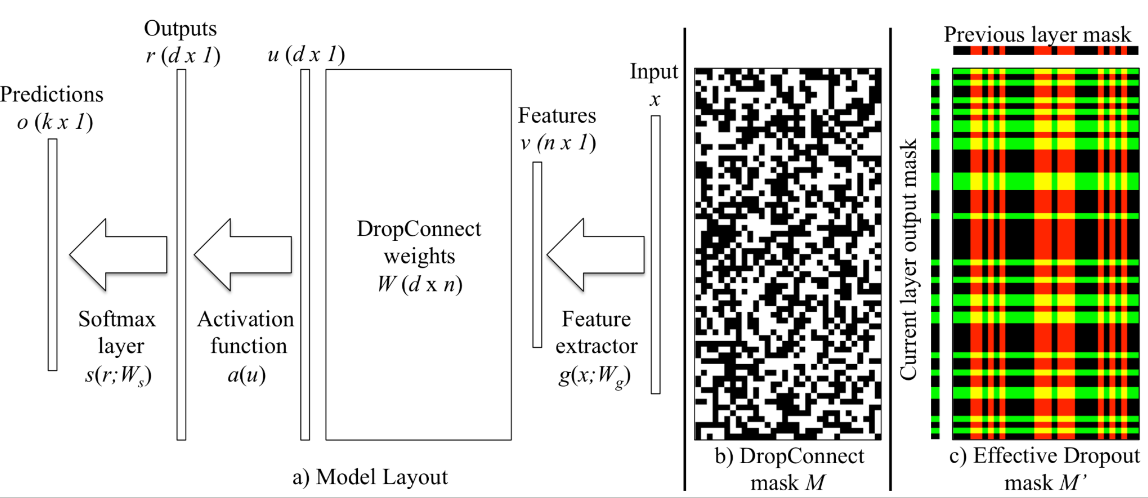

In [151]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.empty(self.linear.weight.shape).uniform_(0, 1).type(torch.FloatTensor)
        mask.requires_grad_(False)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            #mask = torch.where(mask > self.p, 1, 1 - self.p)
            mask = torch.ones_like(mask) * (1 - self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        
        return output

In [152]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.ones_like(mask) * (1 - self.p)

        return x * mask

Основа для сети, которую будем обучать:

In [150]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [162]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10),
]

layers_dropconnect = [
    DropConnect(196, 128),  
    nn.ReLU(),
    DropConnect(128, 128),  
    nn.ReLU(),
    nn.Linear(128, 10),           
]

In [159]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)

Обучим получившуюся сеть:

In [163]:
dropout_results = train(train_loader, test_loader, network_dropout, optimizer_dropout, is_conv=True)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [164]:
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)

In [165]:
dropconnect_results = train(train_loader, test_loader, network_dropout, optimizer_dropout, is_conv=True)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

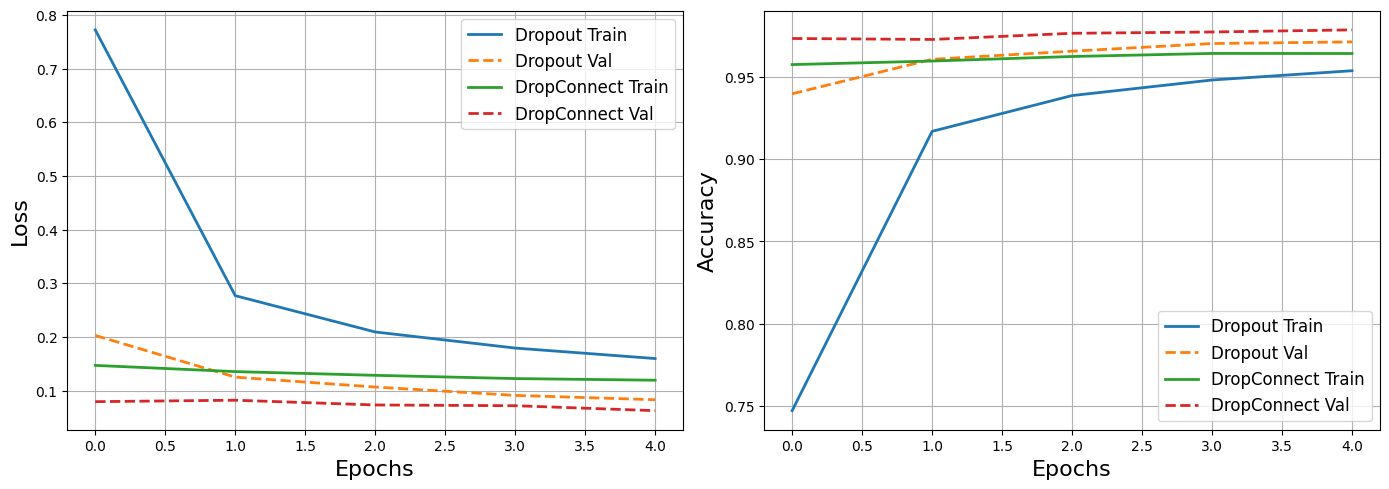

In [168]:
plot_train(dropout_results, dropconnect_results, ['Dropout Train', 'Dropout Val', 'DropConnect Train', 'DropConnect Val'])


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


#### Выводы по Dropout и DropConnect
- DropConnect имеет низкий и стабильный лосс как для train, так и для val, причём с 1 эпохи. Dropout не может
достичь такого результата даже за 5 эпох. Аналогично с accuracy - DropConnect имеет высокую точность с начала обучения
и постепенно понемного увеличивается.
- Dropout по граифку не имеет особой характерности - как будто обучаем без регуляризации. Имеет accuracy на 5 эпохе
меньше, чем у DropConnect.
- DropConnect имеет хорошую обобщающую способность, т.к. разница (gap) по accuracy и loss между train и val минимальна.

Общий вывод: DropConnect победил! Скорее всего это связано с тем, что DropConnect регуляризирует на уровне весов, 
не полностью выключая нейрон, а убирая лишшь часть связей от нейронов, а Dropout регуляризирует на уровне активаций,
то есть полностью выключает нейрон из обучения, что сказывается на скорости обучения и качестве модели.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

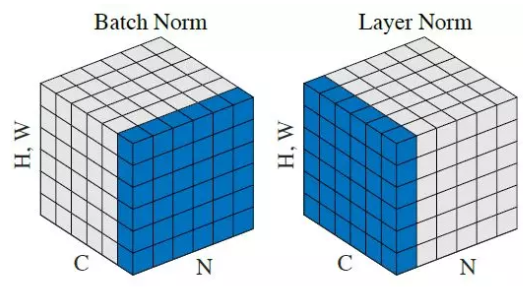

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [176]:
class BatchNormalization(nn.Module):
    def __init__(self, num_features, gamma=1, beta=0, eps=10e-5, alpha=0.1):
        super(BatchNormalization, self).__init__()
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.alpha = alpha

        self.running_mean = torch.zeros(num_features)
        self.running_variance = torch.ones(num_features)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            variance = x.var(dim=0)
            x_norm = (x - mean) / torch.sqrt(variance + self.eps)

            self.running_mean = (1 - self.alpha) * self.running_mean + self.alpha * mean.detach()
            self.running_variance = (1 - self.alpha) * self.running_variance + self.alpha * variance.detach()
        else:
            x_norm = (x - self.running_mean) / torch.sqrt(self.running_variance + self.eps)
            
        output = self.gamma * x_norm + self.beta
        return output

In [177]:
class LayerNormalization(nn.Module):
    def __init__(self, gamma=1, beta=0, eps=1e-5):
        super(LayerNormalization, self).__init__()  
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        
    def forward(self, x):        
        mean = x.mean(dim=1, keepdim=True)  
        var = x.var(dim=1, unbiased=False, keepdim=True)  
        
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        output = self.gamma * x_norm + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [178]:
layers_batch_norm = [
    nn.Linear(196, 128),
    BatchNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    BatchNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

layers_layer_norm = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),

    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),

    nn.Linear(128, 10),          
]

In [179]:
network_batch_norm = TestNetwork(nn.Sequential(*layers_batch_norm))
optimizer_batch_norm = torch.optim.Adam(network_batch_norm.parameters(), lr=0.001)

In [180]:
batch_norm_results = train(train_loader, test_loader, network_batch_norm, optimizer_batch_norm, is_conv=True)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [181]:
network_layer_norm = TestNetwork(nn.Sequential(*layers_layer_norm))
optimizer_layer_norm = torch.optim.Adam(network_layer_norm.parameters(), lr=0.001)

In [182]:
layer_norm_results = train(train_loader, test_loader, network_layer_norm, optimizer_layer_norm, is_conv=True)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

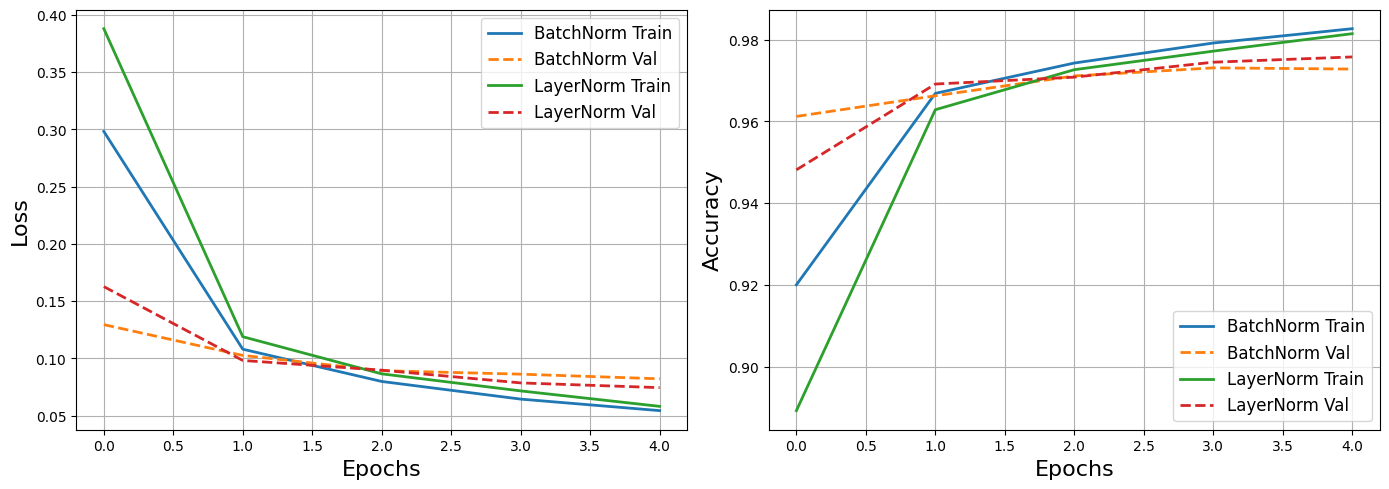

In [183]:
plot_train(batch_norm_results, layer_norm_results, ['BatchNorm Train', 'BatchNorm Val', 'LayerNorm Train', 'LayerNorm Val'])

#### Выводы по BatchNormalization и LayerNormalization
- BatchNormalization быстрее сходится и имеет немного лучшую точность на train.
- Однако LayerNormalization имеет меньший gap, то есть имеет лучшую обобщающую способность, т.к. на валидации
выигрывает LayerNormalization.

Общий вывод: для данной задачи BatchNormalization предпочтительнее из-за более быстрой скорости сходимости и точности.